# AD-NEGF hands-on
This notebook contains the step-by-step information to use AD-NEGF to compute electronic structure and transport properties.

Starting from constructing a Tight-Binding Model:

first, we import the necessary packages.

In [1]:
import ase
import torch
from ase.io import read
from TB.hamiltonian import Hamiltonian
from transport import Transport_tb
from torch.autograd.functional import hessian, jacobian
from Constant import *
from ase.lattice.cubic import FaceCenteredCubic
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import os
from TB.orbitals import Orbitals
from TB.hamiltonian_initializer import set_tb_params, set_tb_params_bond_length

kBT = k * T / eV

In [2]:
def init_syst(file):
    atoms = read(file)
    period = np.array([list(atoms.get_cell()[2])])
    period[:, [1, 2]] = period[:, [2, 1]]
    print(period)
    coord = atoms.get_positions()

    coord[:, [1, 2]] = coord[:, [2, 1]]
    coords = []
    coords.append(str(len(coord)))
    coords.append('C')

    for j, item in enumerate(coord):
        coords.append('C' + str(j + 1) + ' ' + str(item[0]) + ' ' + str(item[1]) + ' ' + str(item[2]))

    coords = '\n'.join(coords)

    return coords, period, atoms



In [3]:
def radial_dependence_func(bond_length, ne_bond_length, param):

        # return (bond_length / ne_bond_length) ** param
        return torch.exp(-param*(ne_bond_length/bond_length-1))

def sorting(coords, **kwargs):
    return np.argsort(coords[:, 1], kind='mergesort')


def plot_dispo_atoms(atoms, dispo, index):
    new_atoms = atoms.copy()
    new_atoms.set_positions(newpositions=new_atoms.get_positions() + dispo[:, [0, 2, 1]])
    # plot_band(atoms=new_atoms)
    # new_atoms.write("./experimental_data/traj/dispo_au_"+str(index)+".vasp")
    plot_atoms(new_atoms, show_unit_cell=2, rotation='90x,0y,270z')
    plt.tight_layout()
    plt.show()



## Band structure of 1st nearest neightbour graphene

C


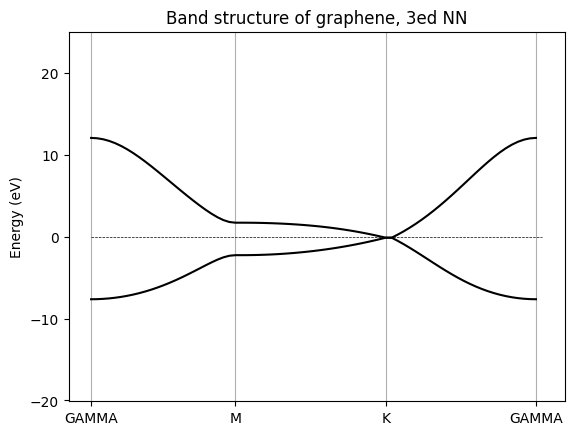

In [4]:
from TB.aux_functions import get_k_coords


lat_const = 1.42
a1 = 0.5 * lat_const * 3
a2 = 0.5 * lat_const * np.sqrt(3)

period = np.array([[a1, a2, 0.0],
                   [a1, -a2, 0.0]])

lat_const_rec = 2 * np.pi / (3 * np.sqrt(3) * lat_const)



special_k_points = {
    'GAMMA': [0, 0, 0],
    'K': [lat_const_rec * np.sqrt(3), lat_const_rec, 0],
    'K_prime': [lat_const_rec * np.sqrt(3), -lat_const_rec, 0],
    'M': [lat_const_rec * np.sqrt(3), 0, 0]
}

sym_points = ['GAMMA', 'M', 'K', 'GAMMA']
num_points = [25, 25, 25]
k_points = get_k_coords(sym_points, num_points, special_k_points)

fig_counter = 1

def graphene_first_nearest_neighbour():

    coords = """2
    Graphene
    C1   0.00   0.00   0.00
    C2   {}   0.00   0.00
    """.format(lat_const)

    s_orb = Orbitals('C')
    s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

    # ------------------------ set TB parameters----------------------

    gamma0 = -2.97
    gamma1 = -0.073
    gamma2 = -0.33
    s0 = 0.073
    s1 = 0.018
    s2 = 0.026

    set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                     PARAMS_C_C2={'pp_pi': gamma1},
                     PARAMS_C_C3={'pp_pi': gamma2},
                     OV_C_C1={'pp_pi': s0},
                     OV_C_C2={'pp_pi': s1},
                     OV_C_C3={'pp_pi': s2})
    


    # --------------------------- Hamiltonian -------------------------

    h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.6, 2.8, 3.2], comp_overlap=True,
    sort_func=None, dtype=torch.complex128)
    h.initialize()
    h.set_periodic_bc(period)

    

    band_structure = np.zeros((sum(num_points), h.h_matrix.shape[0]))

    for jj, item in enumerate(k_points):
        band_structure[jj, :], _ = h.diagonalize_periodic_bc(item)

    # visualize
    global fig_counter
    plt.figure(fig_counter)
    fig_counter += 1
    ax = plt.axes()
    ax.set_title(r'Band structure of graphene, 3ed NN')
    ax.set_ylabel('Energy (eV)')
    ax.plot(np.sort(band_structure), 'k')
    ax.plot([0, band_structure.shape[0]], [0, 0], '--', color='k', linewidth=0.5)
    plt.xticks(np.insert(np.cumsum(num_points) - 1, 0, 0), labels=sym_points)
    ax.xaxis.grid()
    plt.ylim([-20.1, 25])
    plt.show()

graphene_first_nearest_neighbour()

## Band structure of 1st nearest neightbour carbon nanotube

[[2.00000000e-16 2.46680383e+00 2.00000000e-16]]
C
(100, 20)


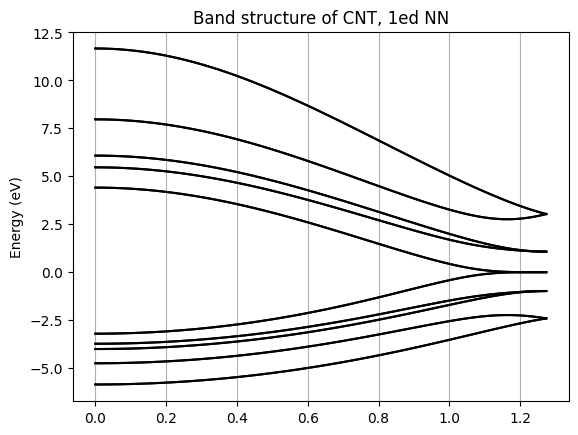

In [4]:
from TB.aux_functions import get_k_coords



fig_counter = 1

def graphene_first_nearest_neighbour():

    coords, period, atoms = init_syst("./data/CNT_medal/POSCAR")
    kpoints = torch.zeros(100, 3).double()
    kpoints[:,1] = torch.linspace(0, 3.14159265/period[0][1], 100)

    
    s_orb = Orbitals('C')
    s_orb.add_orbital("pz", energy=0., orbital=1, magnetic=0, spin=0)

    # ------------------------ set TB parameters----------------------

    t = -3.033
    s = 0.129
    set_tb_params(s_orb, PARAMS_C_C={'pp_pi': t}, OV_C_C={"pp_pi": s})

    c_c = 1.42
    c_c_pow = 3.37

    set_tb_params_bond_length(s_orb, BL_C_C={'bl': c_c, 'pp_pi': c_c_pow}
                              )
    


    # --------------------------- Hamiltonian -------------------------

    h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=1.5, comp_overlap=True,
    sort_func=None, dtype=torch.complex128, radial_dep=radial_dependence_func)
    h.initialize()
    h.set_periodic_bc(period)

    band_structure = np.zeros((len(kpoints), h.h_matrix.shape[0]))
    print(band_structure.shape)

    for jj, item in enumerate(kpoints):
        band_structure[jj, :], _ = h.diagonalize_periodic_bc(item)

    # visualize
    global fig_counter
    plt.figure(fig_counter)
    fig_counter += 1
    ax = plt.axes()
    ax.set_title(r'Band structure of CNT, 1ed NN')
    ax.set_ylabel('Energy (eV)')
    ax.plot(kpoints[:,1], np.sort(band_structure), 'k')
    # ax.plot([0, band_structure.shape[0]], [0, 0], '--', color='k', linewidth=0.5)
    # plt.xticks(np.insert(np.cumsum(num_points) - 1, 0, 0), labels=sym_points)
    ax.xaxis.grid()
    # plt.ylim([-20.1, 25])
    plt.show()

graphene_first_nearest_neighbour()



defining the functions to compute the NEGF transmission, the following computation may takes dozen of minutes.

In [4]:
def getTT(ul, ur, transport_tb, ee, period):
    if isinstance(ul, (float, int)):
        ul = torch.scalar_tensor(ul)
    if isinstance(ur, (float, int)):
        ur = torch.scalar_tensor(ur)
    return transport_tb.negf.calGreen(
        ee=ee,
        ul=ul,
        ur=ur,
        atom_coord=transport_tb.h.get_site_coordinates()[transport_tb.h._offsets],
        d_trains=1,
        left_pos=period[0][0],
        right_pos=period[0][1],
        offset=transport_tb.h._offsets,
        calDOS=False,
        calTT=True,
        calSeebeck=False,
        etaLead=1e-6,
        etaDevice=0.,
        ifSCF=True,
        n_int_neq=100,
        cutoff=False,
        sgfMethod='Lopez-Schro'
    )['TT']

[[ 0.         51.12000275  0.        ]]
C


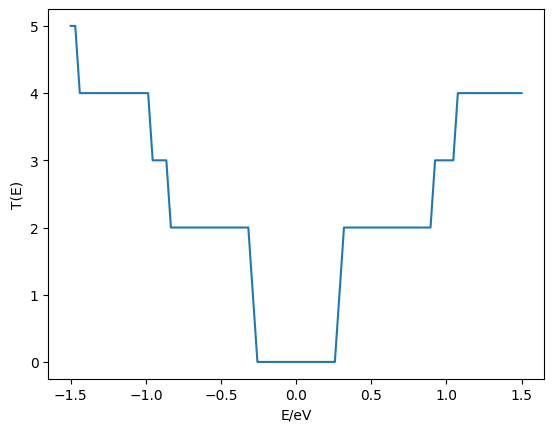

In [6]:
import matplotlib.pyplot as plt


# ------------------------ set TB parameters----------------------
ul = 0
ur = 0
ee = torch.linspace(-1.5, 1.5, 100)
coords, period, atoms = init_syst("./data/C.vasp")

s_orb = Orbitals('C')
s_orb.add_orbital("pz", energy=0., orbital=1, magnetic=0, spin=0)
# s_orb.add_orbital("py", energy=0, orbital=1, magnetic=1, spin=0)
# s_orb.add_orbital("px", energy=0, orbital=1, magnetic=-1, spin=0)

# ------------------------ set TB parameters----------------------

t = -3.033
s = 0.129
set_tb_params(s_orb, PARAMS_C_C={'pp_pi': t}, OV_C_C={"pp_pi": s})

c_c = 1.42
c_c_pow = 3.37

set_tb_params_bond_length(s_orb, BL_C_C={'bl': c_c, 'pp_pi': c_c_pow}
                            )

transport_tb = Transport_tb(
    radial_dep=radial_dependence_func, xyz=coords, xyz_new=coords,
    period=period, nn_distance=1.7, comp_overlap=True,
    sort_func=sorting, dtype=torch.complex128
)

TT = getTT(ul=ul, ur=ur, transport_tb=transport_tb, ee=ee, period=period)

plt.plot(ee, TT)
plt.xlabel("E/eV")
plt.ylabel("T(E)")
plt.show()

# Current of 1NN nanotube


In [5]:
from tqdm import tqdm
s_orb = Orbitals('C')
s_orb.add_orbital("pz", energy=0., orbital=1, magnetic=0, spin=0)
# ------------------------ set TB parameters----------------------

t = -3.033
s = 0.129
set_tb_params(s_orb, PARAMS_C_C={'pp_pi': t}, OV_C_C={"pp_pi": s})

c_c = 1.42
c_c_pow = 3.37

set_tb_params_bond_length(s_orb, BL_C_C={'bl': c_c, 'pp_pi': c_c_pow}
                            )


# __________________________________ calc _________________________________
ul = 0
ur = 0
ee = torch.linspace(-4.5, 4.5, 200)
coords, period, atoms = init_syst("./data/CNT/SPOSCAR")

transport_tb = Transport_tb(
    radial_dep=radial_dependence_func, xyz=coords, xyz_new=coords,
    period=period, nn_distance=1.5, comp_overlap=True,
    sort_func=sorting, dtype=torch.complex128
)

current = []
for i in tqdm(range(10)):

    I = transport_tb.negf.calCurrent_NUM(
        ul=ul, 
        ur=i*0.2,
        ifSCF=True,
        atom_coord=transport_tb.h.get_site_coordinates()[transport_tb.h._offsets],
        d_trains=1,
        left_pos=period[0][0],
        right_pos=period[0][1],
        offset=transport_tb.h._offsets,
        n_img=500
        )
    
    current.append(I)

print(torch.tensor(current))

[[ 0.         34.08000183  0.        ]]
C


 10%|█         | 1/10 [00:22<03:25, 22.84s/it]

Converged very well at 3.
Convergence achieved !


 20%|██        | 2/10 [03:53<17:47, 133.45s/it]

Converged very well at 6.
Convergence achieved !


 30%|███       | 3/10 [08:59<24:45, 212.17s/it]

Converged very well at 6.
Convergence achieved !


 40%|████      | 4/10 [14:07<24:59, 249.90s/it]

Converged very well at 6.
Convergence achieved !


 50%|█████     | 5/10 [20:14<24:21, 292.30s/it]

Converged very well at 6.
Convergence achieved !


 60%|██████    | 6/10 [26:33<21:26, 321.54s/it]

Converged very well at 6.
Convergence achieved !


 70%|███████   | 7/10 [33:31<17:39, 353.05s/it]

Converged very well at 12.
Convergence achieved !


 80%|████████  | 8/10 [43:08<14:09, 424.61s/it]

Converged very well at 9.
Convergence achieved !


 90%|█████████ | 9/10 [52:23<07:45, 465.17s/it]

Converged very well at 18.
Convergence achieved !


100%|██████████| 10/10 [1:05:33<00:00, 393.30s/it]

tensor([2.6443e-11, 4.3972e-06, 1.1939e-05, 1.4474e-03, 8.4661e-02, 2.0374e-01,
        3.2290e-01, 4.6359e-01, 5.9494e-01, 7.2357e-01], dtype=torch.float64)


tensor([2.6443e-11, 4.3972e-06, 1.1939e-05, 1.4474e-03, 8.4661e-02, 2.0374e-01,
        3.2290e-01, 4.6359e-01, 5.9494e-01, 7.2357e-01], dtype=torch.float64)


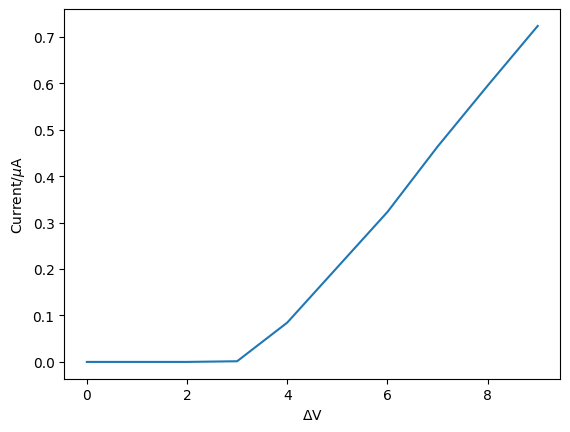

In [6]:
print(torch.tensor(current))

import matplotlib.pyplot as plt
plt.plot(current)
plt.xlabel(r"$\Delta$V")
plt.ylabel(r"Current/$\mu$A")
plt.show()